# Immersed Cylinder benchmarking

![image](media/close_up.png)

This notebook will contain all the required scripts and commands to produce the
benchmarking for the immersed cylinder case.

We expect the simulation for the `cylinder_benchmark` example have been
completed and that the resulting data is available in the `cylinder_benchmark`
subdirectory of the results folder.

The benchmarking consists of a few different sub-benchmarks:

1. Inflection point detection.
2. Backdraft region detection.
3. Leakage detection.



In [60]:
# Assign flags for debugging to alter the behaviour of the program in addition
# to the list of experiments to compare.

debug = False
root_folder = "../../"
data_folder = "results/hpc/cylinder_benchmark"

# Define the list of data files and the labels to give them
experiments = [
    "meshed",
    "explicit_100",
    "explicit_200",
    "explicit_400",
    "explicit_800",
]
labels = [
    "Baseline",
    "Explicit 100",
    "Explicit 200",
    "Explicit 400",
    "Explicit 800",
]

In [61]:
# Setup the paths for the project and load the external modules

# Load the external modules
import sys
import os

try:
    import import_ipynb
    import numpy as np
except:
    print("import_ipynb not installed. Installing it now.")
    %pip install import_ipynb numpy
    import import_ipynb
    import numpy as np

# Load internal modules
try:
    from nekotop import *
except:
    sys.path.append(root_folder + "scripts/modules")
    from nekotop import *

# If the data folder is not an absolute path, make it relative to the root
if data_folder[0] != "/":
    data_folder = os.path.realpath(os.path.join(root_folder, data_folder))

# Check that the folder exists
if not os.path.exists(data_folder):
    raise FileNotFoundError(
        "The path to the results folder does not exist.\n"
        "Please run the benchmark first.\n"
        "\tcd NEKO_TOP_ROOT\n"
        "\t./setup.sh\n"
        "\t./run.sh cylinder_benchmark\n"
    )



# Inflection point detection

Separation points are detected by looking for inflection points in the flow
field around the cylinder. The inflection points are detected by looking for
zero crossings in the velocity component tangential to the cylinder surface.

The angle of the separation point is then calculated by looking at the angle
between the separation point and x axis. This angle provides a time series as
vortices are build and shedd. These time series will be almost impossible to
line up between the meshed cylinder and the immersed boundary cylinder, but the
overall trend should be similar.

We will be computing a number of statistical measures to compare.

- The mean angle of the separation point, or the bias of the signal.
- The amplitude of the signal.
- The dominant frequency of the signal.
- The Strouhal number for the flow.

We expect to see the signal to be separated into 3 parts, the build up of the
boundary layer, build-up of the vortex and the shedding of the vortex. All the
measures are computed for the stable phase shedding of vortices.

Please see the [inflection point detection notebook](inflection_points.ipynb)
for more details on the derivations. Here we just execute the script and show the
results.

In [62]:
# Import the inflection benchmark and run it for all the data files
#
# This cell will import and run the inflection point benchmarking for all the
# data files in the folder. The benchmark will compare the data to the baseline
# and produce a plot of the inflection points for each case.

from inflection_points import inflection_benchmark

# Run the benchmark
if "inflection" not in locals() or debug:
    inflection = []
    for i in range(len(experiments)):
        inflection.append(
            inflection_benchmark(
                os.path.join(data_folder, experiments[i], "inflection.csv")))

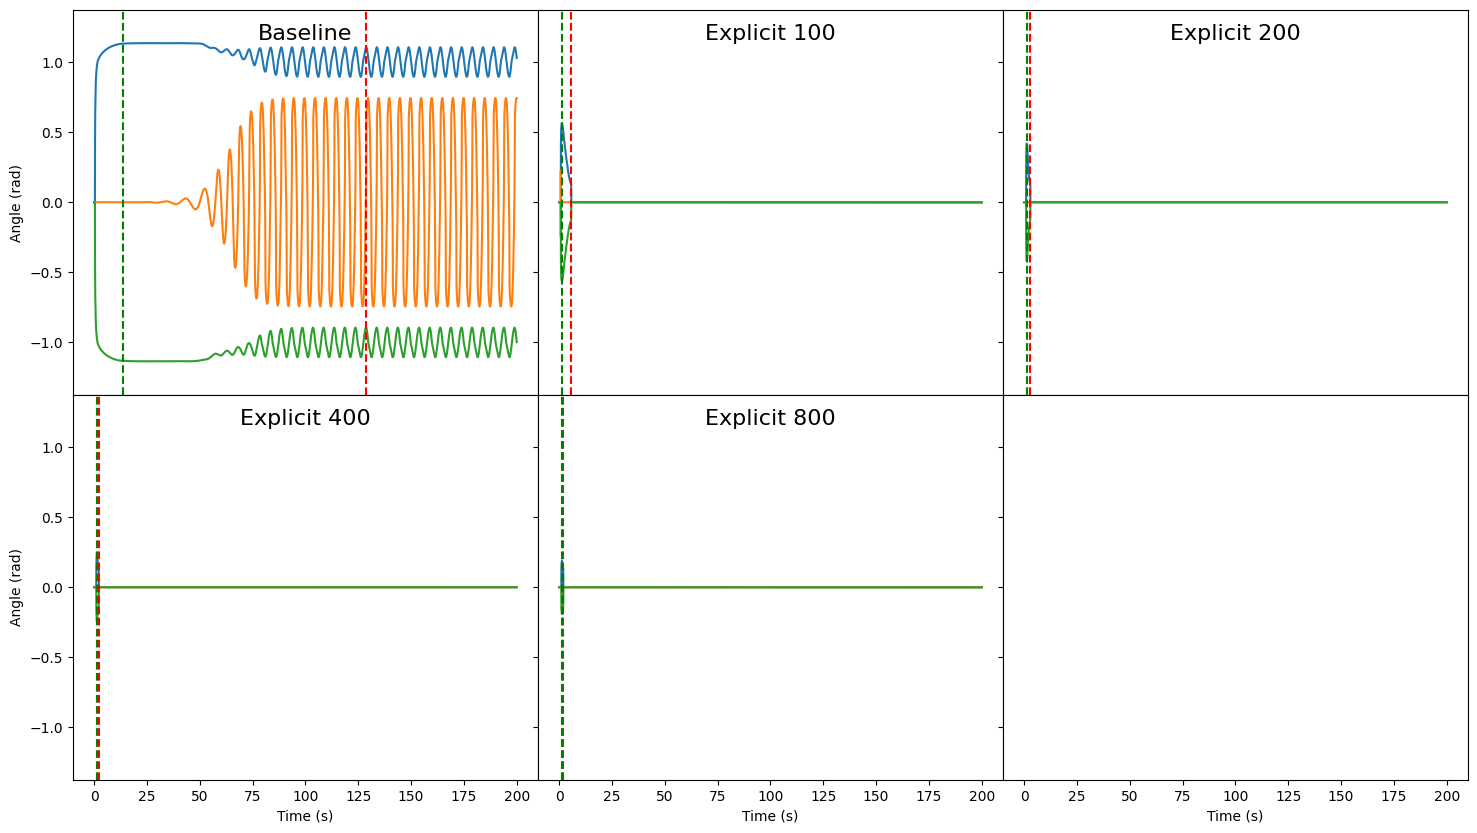

In [83]:
# Plot the inflection point angles for each case
import matplotlib.pyplot as plt

max_columns = 3

rows = len(experiments) // max_columns + 1
columns = min(len(experiments), max_columns)

fig = plt.figure(figsize=(6 * columns, 5 * rows))
gs = fig.add_gridspec(rows, columns, hspace=0, wspace=0)
ax = gs.subplots(sharex=True, sharey=True)

(x0, x1, y0, y1) = (float("inf"), float("-inf"), float("inf"), float("-inf"))

for i in range(len(experiments)):
    idx = (i // max_columns, i % max_columns)

    # Plot the inflection angles
    ax[idx].plot(inflection[i]["times"], inflection[i]["angles"])

    # Add vertical lines to show the building and layer formation times
    ax[idx].axvline(
        inflection[i]["times"][inflection[i]["i_building"]],
        color="red",
        linestyle="--",
        label="Vortex build-up time",
    )
    ax[idx].axvline(
        inflection[i]["times"][inflection[i]["i_boundary"]],
        color="green",
        linestyle="--",
        label="Boundary formation time",
    )

    ax[idx].set_title(labels[i], x=0.5, y=0.9, fontsize=16)

    x0 = min(x0, ax[idx].axis()[0])
    x1 = max(x1, ax[idx].axis()[1])
    y0 = min(y0, ax[idx].axis()[2])
    y1 = max(y1, ax[idx].axis()[3])

for idx in np.ndindex(rows, columns):

    ax[idx].axis([x0, x1, 1.1*y0, 1.1*y1])

    if idx[0] == rows - 1:
        ax[idx].set_xlabel("Time (s)")
    if idx[1] == 0:
        ax[idx].set_ylabel("Angle (rad)")

In [64]:
# Print the bias of the inflection points

def print_bias(benchmark):
    bias = benchmark["bias"]
    return f"{bias[0]:9.3f} | {bias[1]:9.3f} | {bias[2]:9.3f}"


print(f"| {'Bias [rad]':30s} | {'':9s} | {'':9s} | {'':9s} |")
print(f"| {'':{'-'}^30s} | {'':{'-'}^9s} | {'':{'-'}^9s} | {'':{'-'}^9s} |")
for i in range(len(inflection)):
    print(f"| {labels[i]:30s} | " + print_bias(inflection[i]) + " |")


| Bias [rad]                     |           |           |           |
| ------------------------------ | --------- | --------- | --------- |
| Baseline                       |     1.006 |     0.010 |    -1.004 |
| Explicit 100                   |    -0.000 |    -0.000 |    -0.000 |
| Explicit 200                   |    -0.000 |    -0.000 |    -0.000 |
| Explicit 400                   |     0.000 |     0.000 |     0.000 |
| Explicit 800                   |    -0.000 |    -0.000 |    -0.000 |


In [65]:
# Print the dominant frequency of the inflection points

def print_freq(benchmark):
    freq = benchmark["max_freq"]
    return f"{freq[0]:9.3f} | {freq[1]:9.3f} | {freq[2]:9.3f}"


print(f"| {'Frequency: [Hz]':30s} | {'':9s} | {'':9s} | {'':9s} |")
print(f"| {'':{'-'}^30s} | {'':{'-'}^9s} | {'':{'-'}^9s} | {'':{'-'}^9s} |")
for i in range(len(inflection)):
    print(f"| {labels[i]:30s} | " + print_freq(inflection[i]) + " |")


| Frequency: [Hz]                |           |           |           |
| ------------------------------ | --------- | --------- | --------- |
| Baseline                       |     0.196 |     0.196 |     0.196 |
| Explicit 100                   |     0.124 |     0.124 |     0.124 |
| Explicit 200                   |     0.127 |     0.127 |     0.127 |
| Explicit 400                   |     0.126 |     0.126 |     0.126 |
| Explicit 800                   |     0.126 |     0.126 |     0.126 |


In [66]:
# Print the amplitude of the inflection points movement

def print_amp(benchmark):
    amp = benchmark["amplitude"]
    return f"{amp[0]:9.3f} | {amp[1]:9.3f} | {amp[2]:9.3f}"


print(f"| {'Amplitude: [rad]':30s} | {'':9s} | {'':9s} | {'':9s} |")
print(f"| {'':{'-'}^30s} | {'':{'-'}^9s} | {'':{'-'}^9s} | {'':{'-'}^9s} |")
for i in range(len(inflection)):
    print(f"| {labels[i]:30s} | " + print_amp(inflection[i]) + " |")


| Amplitude: [rad]               |           |           |           |
| ------------------------------ | --------- | --------- | --------- |
| Baseline                       |     0.211 |     1.489 |     0.211 |
| Explicit 100                   |     0.002 |     0.002 |     0.002 |
| Explicit 200                   |     0.000 |     0.000 |     0.000 |
| Explicit 400                   |     0.000 |     0.000 |     0.000 |
| Explicit 800                   |     0.001 |     0.001 |     0.001 |


In [67]:
# Print the Strouhal number for each case
#
# The Strouhal number is a dimensionless number that describes the oscillation
# of a body in a fluid. It is defined as:
#
#     St = f * D / U
#
# where:
#     f: frequency of oscillation
#     D: diameter of the body
#     U: ambient velocity of the fluid
#
# The Strouhal number is a useful number to compare the oscillation of bodies
# of different sizes and in different fluids. It is also useful to compare the
# oscillation of bodies in different flow regimes.
#
# We will compute the Strouhal number for each inflection point in each case and
# print the mean value of the Strouhal number for each case.

def compute_strouhal(frequencies, diameter, ambient_velocity):
    return np.asarray([f * diameter / ambient_velocity for f in frequencies])

def print_strouhal(benchmark):
    st = compute_strouhal(benchmark["max_freq"], 1.0, 1.0).mean()
    return f"{st:9.3f}"

print(f"| {'Strouhal number':30s} | {'':9s} |")
print(f"| {'':{'-'}^30s} | {'':{'-'}^9s} |")
for i in range(len(inflection)):
    print(f"| {labels[i]:30s} | " + print_strouhal(inflection[i]) + " |")

| Strouhal number                |           |
| ------------------------------ | --------- |
| Baseline                       |     0.196 |
| Explicit 100                   |     0.124 |
| Explicit 200                   |     0.127 |
| Explicit 400                   |     0.126 |
| Explicit 800                   |     0.126 |


In [68]:
# Print the boundary layer building time

def print_layer_time(benchmark):
    i = benchmark["i_boundary"]
    return f"{benchmark['times'][i]:9.3f}"


print(f"| {'Layer formation time: [s]':30s} | {'':9s} |")
print(f"| {'':{'-'}^30s} | {'':{'-'}^9s} |")
for i in range(len(inflection)):
    print(f"| {labels[i]:30s} | " + print_layer_time(inflection[i]) + " |")


| Layer formation time: [s]      |           |
| ------------------------------ | --------- |
| Baseline                       |    13.606 |
| Explicit 100                   |     1.355 |
| Explicit 200                   |     1.302 |
| Explicit 400                   |     1.353 |
| Explicit 800                   |     1.362 |


In [69]:
# Print the building time for each case

def print_building_time(benchmark):
    i = benchmark["i_building"]
    return f"{benchmark['times'][i]:9.3f}"


print(f"| {'Building time: [s]':30s} | {'':9s} |")
print(f"| {'':{'-'}^30s} | {'':{'-'}^9s} |")
for i in range(len(inflection)):
    print(f"| {labels[i]:30s} | " + print_building_time(inflection[i]) + " |")


| Building time: [s]             |           |
| ------------------------------ | --------- |
| Baseline                       |   128.678 |
| Explicit 100                   |     5.773 |
| Explicit 200                   |     2.967 |
| Explicit 400                   |     2.263 |
| Explicit 800                   |     2.007 |
